# 📊 Classificação de Custo-Benefício de Smartphones (RandomForest)

Este notebook realiza a criação de uma variável `CustoBeneficio` (baixo, médio, alto) com base em características técnicas dos smartphones,
como bateria, memória, câmeras, tela e preço. Em seguida, treinamos um modelo de classificação **Random Forest** para prever essa categoria
com base nos dados, e avaliamos a performance do modelo com matriz de confusão e métricas de classificação.


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Display settings
plt.rcParams.update({"axes.labelsize": 11, "axes.titlesize": 13, "figure.autolayout": True})
sns.set_style("whitegrid")

# Set this to your Excel file path
EXCEL_FILE = "D:/Projetos/faculdade/PISI3GP6/datasets/pisi3basededados.xlsx"

In [132]:
df = pd.read_excel(EXCEL_FILE)
df.columns = df.columns.str.strip()

# Basic cleaning and new columns
df["Preço (USD)"] = (
    df["Launched Price (USA)"]
    .astype(str)
    .str.replace("USD", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

df["Memoria Interna (GB)"] = (
    df["RAM"]
    .astype(str)
    .str.replace("GB", "", regex=False)
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.strip()
    .astype(float)
)
df["Câmera Frontal (MP)"] = (
    df["Front Camera"]
    .astype(str)
    .str.replace("MP", "", regex=False)
    .str.replace("Dual ", "", regex=False)  # Remove tudo após "/"
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.replace(r"\+.*", "", regex=True)  # Remove tudo após "+"
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .str.strip()
    .astype(float)
)
df["Câmera Traseira (MP)"] = (
    df["Back Camera"]
    .astype(str)
    .str.replace("MP", "", regex=False)
    .str.replace("Dual ", "", regex=False)  # Remove tudo após "/"
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.replace(r"\+.*", "", regex=True)  # Remove tudo após "+"
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .str.strip()
    .astype(float)
)
df["Tela (polegadas)"] = (
    df["Screen Size"]
    .astype(str)
    .str.replace(" inches", "", regex=False)
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .astype(float)
)
df["Bateria (mAh)"] = (
    df["Battery Capacity"]
    .astype(str)
    .str.replace("mAh", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# Remove unnecessary columns
df.drop(
    columns=[
        "Mobile Weight",
        "Launched Price (USA)",
        "Battery Capacity",
        "RAM",
        "Front Camera",
        "Back Camera",
        "Screen Size",
        "Launched Year",
        "Company Name",
        "Model Name",
        "Processor",
        "Sistema Operacional",

    ],
    inplace=True
)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (373, 6)


,Preço (USD),Memoria Interna (GB),Câmera Frontal (MP),Câmera Traseira (MP),Tela (polegadas),Bateria (mAh)
0,799.0,6.0,12.0,48.0,6.1,3600.0
1,849.0,6.0,12.0,48.0,6.1,3600.0
2,899.0,6.0,12.0,48.0,6.1,3600.0
3,899.0,6.0,12.0,48.0,6.7,4200.0
4,949.0,6.0,12.0,48.0,6.7,4200.0


### Normalizacao das colunas usadas para calcular o Score

In [133]:
benefit_cols = [
    "Memoria Interna (GB)",
    "Câmera Frontal (MP)",
    "Câmera Traseira (MP)",
    "Tela (polegadas)",
    "Bateria (mAh)",
    "Preço (USD)"
]

for col in benefit_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df_clean = df.dropna(subset=benefit_cols).copy()

# Normalização z-score
for col in benefit_cols:
    df_clean[f"z_{col}"] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()

### Calculando o score e custo beneficio

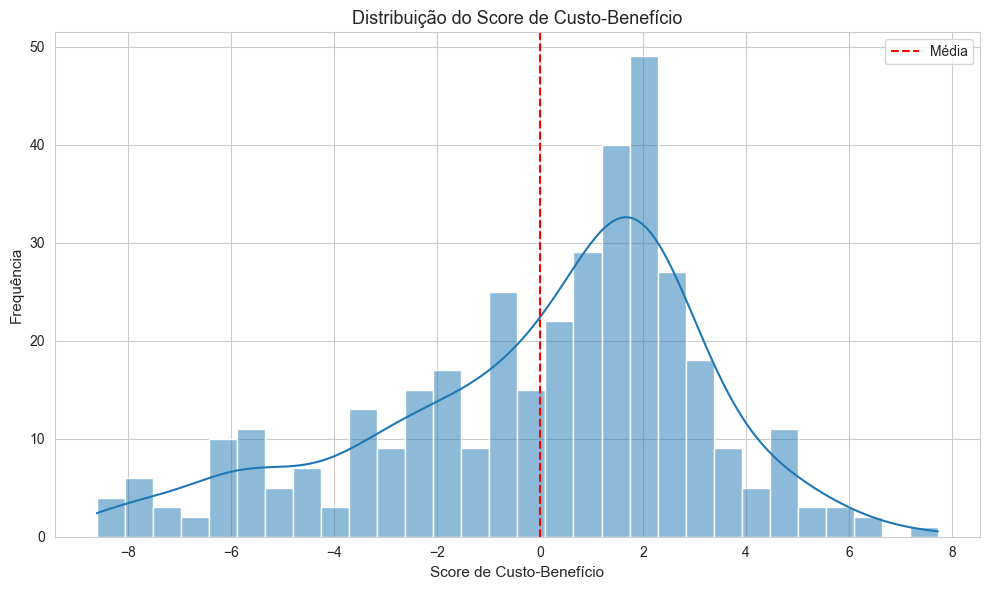

Dataset shape: (373, 6)


,z_Memoria Interna (GB),z_Câmera Frontal (MP),z_Câmera Traseira (MP),z_Tela (polegadas),z_Bateria (mAh),z_Preço (USD),CustoBeneficio
0,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.242041,Baixo
1,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.345259,Baixo
2,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.448477,Baixo
3,-0.506369,-0.472756,-0.047917,0.368147,-0.422572,0.448477,Baixo
4,-0.506369,-0.472756,-0.047917,0.368147,-0.422572,0.551695,Baixo


In [134]:
# Score ponderado
df_clean["score"] = (
    df_clean["z_Bateria (mAh)"] +
    df_clean["z_Câmera Traseira (MP)"] * 0.7 +
    df_clean["z_Câmera Frontal (MP)"] * 0.3 +
    df_clean["z_Memoria Interna (GB)"] +
    df_clean["z_Tela (polegadas)"] -
    df_clean["z_Preço (USD)"] * 1.5
)

# Classificação em faixas
df_clean["CustoBeneficio"] = pd.qcut(df_clean["score"], 3, labels=["Baixo", "Médio", "Alto"])

# Visualização da distribuição do score
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["score"], bins=30, kde=True)
plt.title("Distribuição do Score de Custo-Benefício")
plt.xlabel("Score de Custo-Benefício")
plt.ylabel("Frequência")
plt.axvline(df_clean["score"].mean(), color='red', linestyle='--', label='Média')
plt.legend()
plt.show()

# Remove colunas iniciais
df_clean.drop(columns=(benefit_cols + ["score"]), inplace=True)

print("Dataset shape:", df.shape)
df_clean.head()

### Separando os dados de treino e teste

In [135]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_clean.drop('CustoBeneficio', axis=1)
y = df_clean['CustoBeneficio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (261, 6)
Testing set shape: (112, 6)


### Treinando o modelo e fazendo predicoes

In [136]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

### Importancia das features

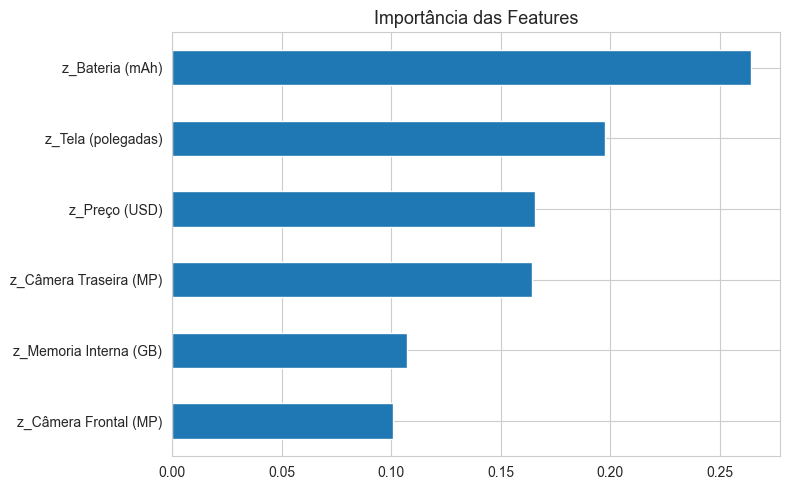

In [137]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Importância das features
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,5), title='Importância das Features')
plt.show()

### Gerando a matriz de confusao


Classification Report - Test Data:
              precision    recall  f1-score   support

        Alto       0.86      0.94      0.90        33
       Baixo       0.98      0.93      0.95        43
       Médio       0.86      0.83      0.85        36

    accuracy                           0.90       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112



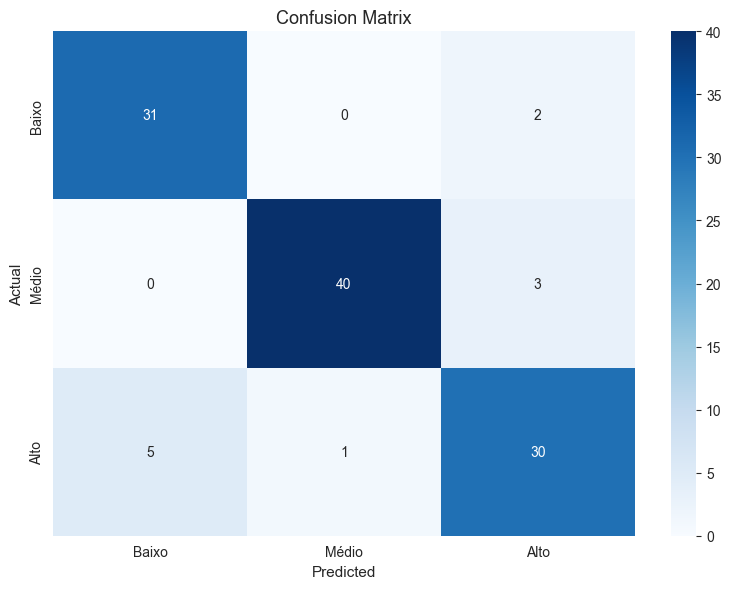


Classification Report - Training Data:
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00        92
       Baixo       1.00      1.00      1.00        81
       Médio       1.00      1.00      1.00        88

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



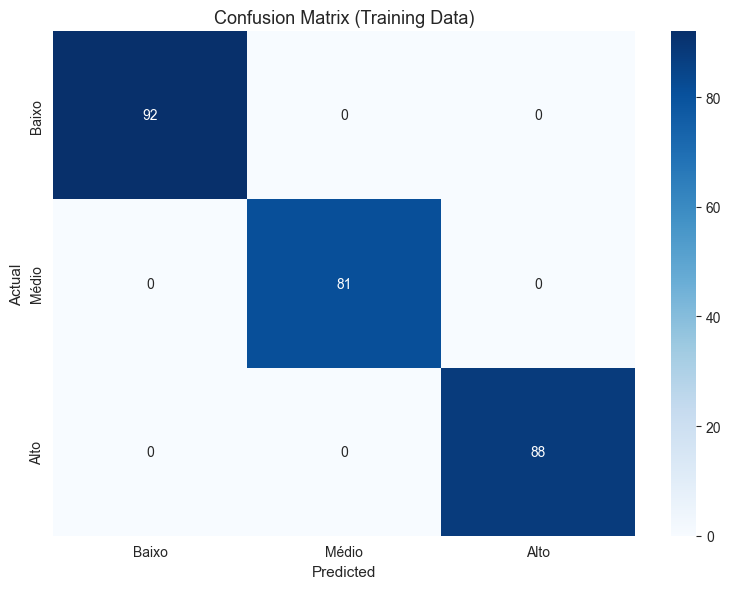

In [138]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baixo', 'Médio', 'Alto'], 
            yticklabels=['Baixo', 'Médio', 'Alto'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Make predictions on training data
y_train_pred = rf_model.predict(X_train)

# Generate the confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\nClassification Report - Training Data:")
print(classification_report(y_train, y_train_pred))

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baixo', 'Médio', 'Alto'], 
            yticklabels=['Baixo', 'Médio', 'Alto'])
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Arvore de decisao do RandomForest (Primeira arvore)

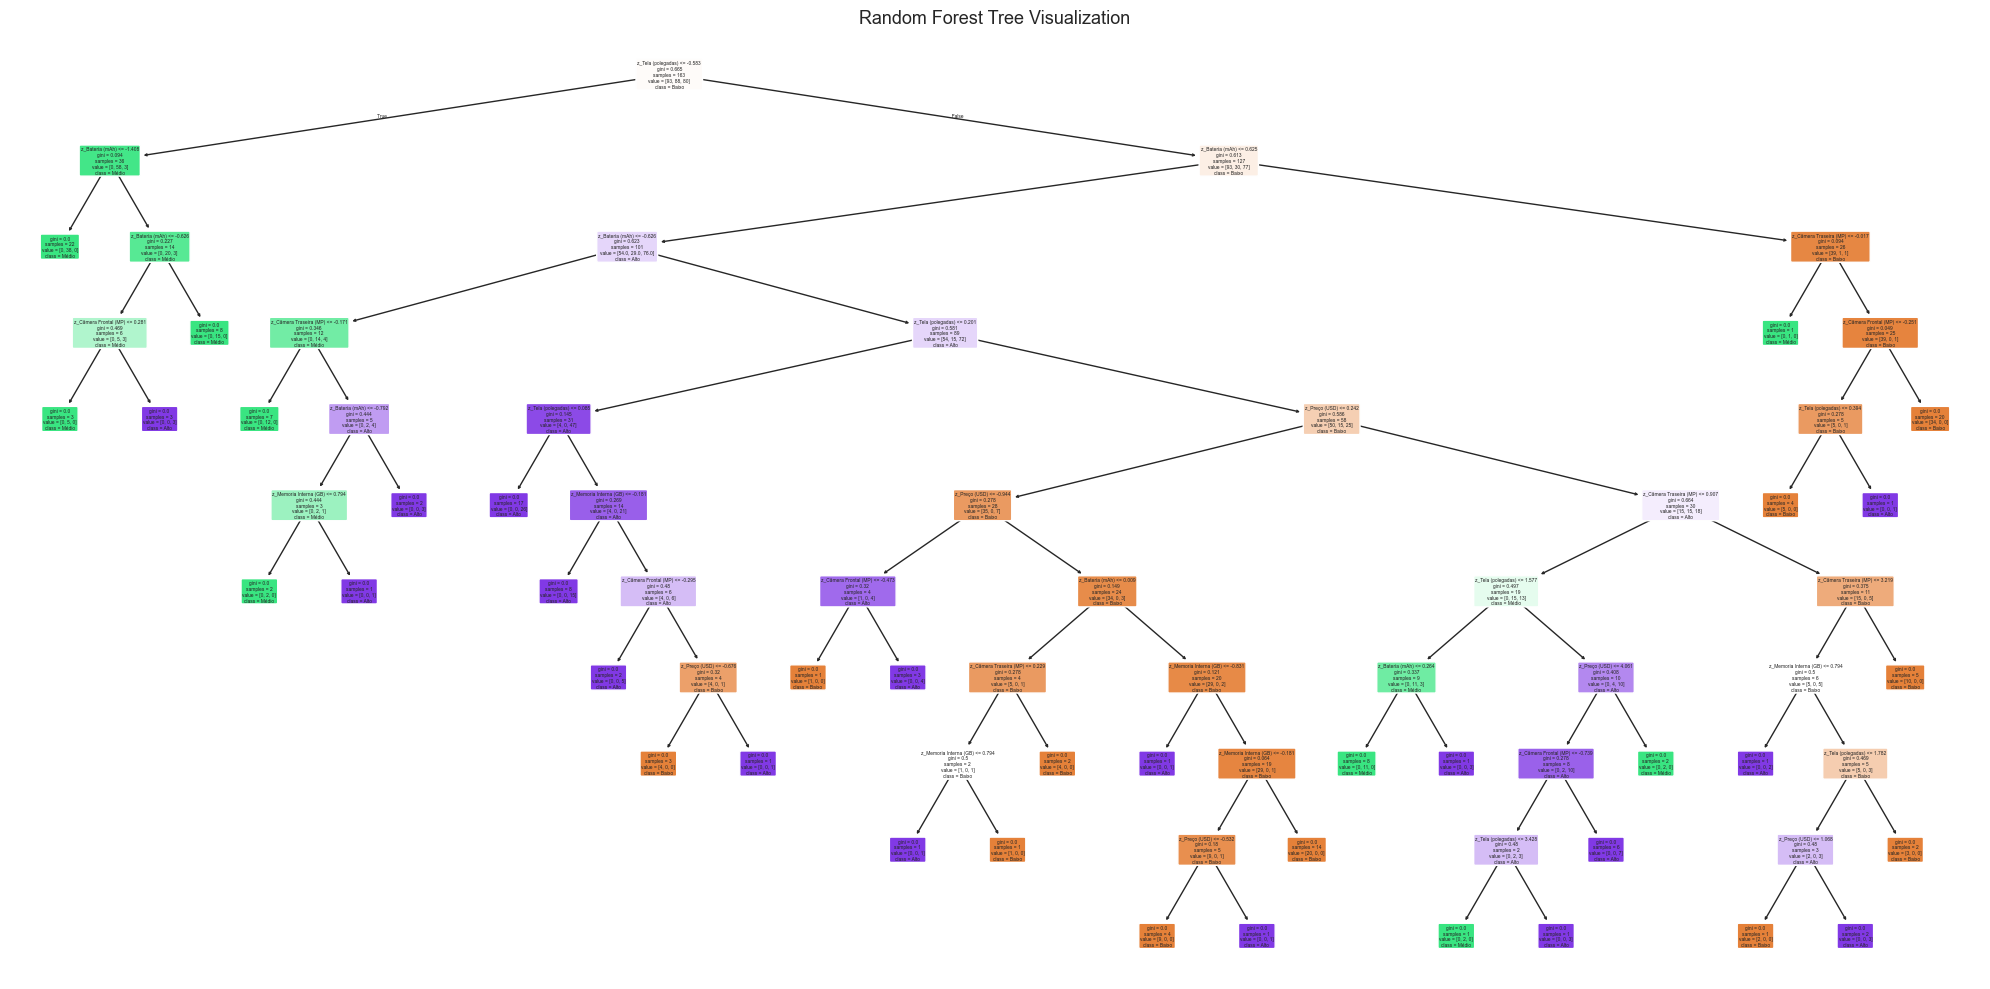

In [139]:
from sklearn.tree import plot_tree

tree_plot = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_plot, feature_names=X.columns, class_names=['Baixo', 'Médio', 'Alto'], filled=True, rounded=True)
plt.title('Random Forest Tree Visualization')
plt.show()



### SHAP


SHAP Feature Importance (Summary Plot - Beeswarm):


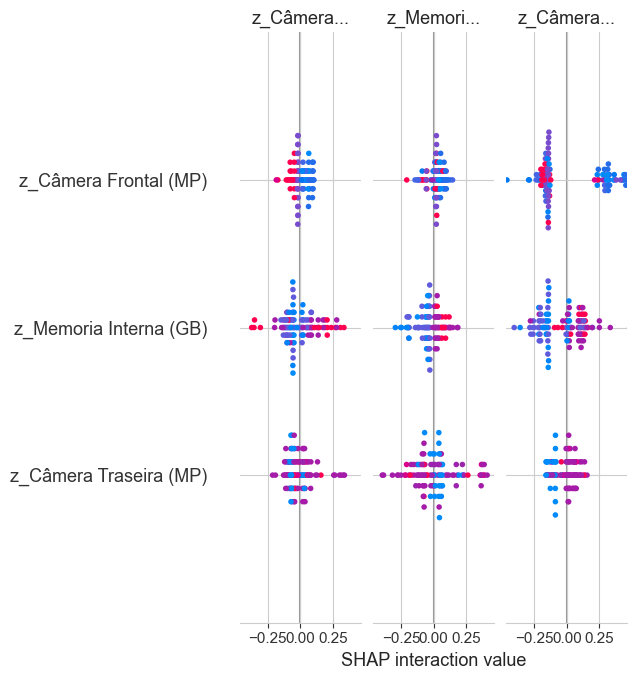


SHAP Feature Importance (Bar Plot):


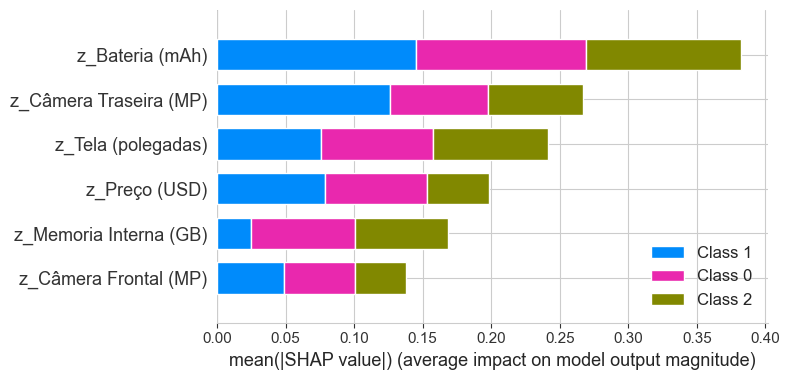

In [140]:
import shap

# Cria um TreeExplainer para o modelo Random Forest
explainer = shap.TreeExplainer(rf_model)

# Prepara os dados de teste para o SHAP
X_test_rf_df = pd.DataFrame(X_test, columns=X.columns)

# Calcula os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test_rf_df)

print("\nSHAP Feature Importance (Summary Plot - Beeswarm):")
shap.summary_plot(shap_values, X_test_rf_df)

print("\nSHAP Feature Importance (Bar Plot):")
shap.summary_plot(shap_values, X_test_rf_df, plot_type="bar")
